# TP Final: Series de tiempo
EEA - 2C 2022

**Alumnos**: 

Exequiel Di Marzo Broggio

Mauricio Acatto

*fuente: https://colab.research.google.com/drive/1rSFZK00noj29uYXGh0athS-pyVGZWhG7?usp=sharing*

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

###**Leer conjunto de datos**


In [ ]:
#Descargar archivo
!gdown 1uixL94YbFRdJTnC-soxC-j84nAnVOj0p

Downloading...
From: https://drive.google.com/uc?id=1uixL94YbFRdJTnC-soxC-j84nAnVOj0p
To: /content/datos_SmartPhone6in_traspuesta.csv
100% 1.87k/1.87k [00:00<00:00, 3.10MB/s]


In [ ]:
#Preparar funcion para conversion 'Period' a fecha (requiere ARIMA)
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y%b')

#Lectura
df = pd.read_csv("datos_SmartPhone6in_traspuesta.csv",parse_dates=['Period'], date_parser=dateparse)
df = df.set_index('Period').asfreq("MS")
df.sort_index(inplace=True)
df.head()

,Month,Year,Industry_Volume,OFS_Advertising and Promotion,OFS_Avg Selling Price,OFS_Volume
Period,,,,,,
2019-01-01,Jan,2019,NaN,7487.0,NaN,NaN
2019-02-01,Feb,2019,NaN,8831.0,NaN,NaN
2019-03-01,Mar,2019,NaN,8881.0,NaN,NaN
2019-04-01,Apr,2019,NaN,8166.0,NaN,NaN
2019-05-01,May,2019,NaN,6606.0,NaN,NaN


In [ ]:
#Datos Volumen
volumen = df[df['OFS_Volume'].notnull()]['OFS_Volume']
volumen

Period
2020-01-01    332315.0
2020-02-01    352779.0
2020-03-01    602449.0
2020-04-01    404545.0
2020-05-01    468849.0
2020-06-01    583919.0
2020-07-01    391096.0
2020-08-01    673307.0
2020-09-01    470361.0
2020-10-01    451750.0
2020-11-01    347201.0
2020-12-01    389135.0
2021-01-01    200309.0
2021-02-01    209270.0
2021-03-01    271392.0
2021-04-01    195322.0
2021-05-01    234505.0
2021-06-01    281903.0
2021-07-01    215041.0
2021-08-01    170419.0
2021-09-01    197890.0
2021-10-01    193506.0
2021-11-01    172818.0
2021-12-01    229805.0
Freq: MS, Name: OFS_Volume, dtype: float64

# **Modelo ARIMA**


Modelos ARIMA, su nombre se debe a que es un modelo autoregresivo y media movil es decir el modelo se constituye de un componente a partir de observaciones de periodos pasado y el promedio en una ventana del tiempo. 

Modelo univariado.

###**Supuestos**

#### Estacionariedad de la serie

Verificación de la estacionariedad de la serie

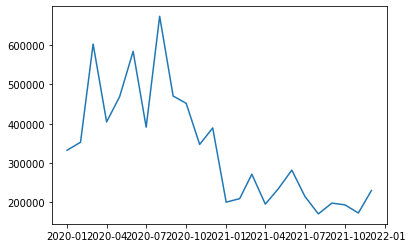

In [39]:
plt.plot(volumen);

A simple vista los datos parecen tener una tendencia lo que nos estaría indicando que se trata de una serie no estacionaria.

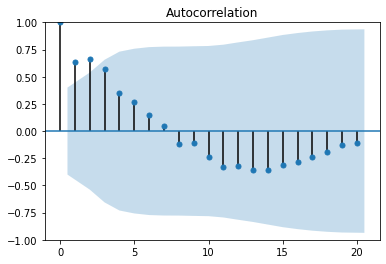

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(np.asarray(volumen), lags=20)

plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


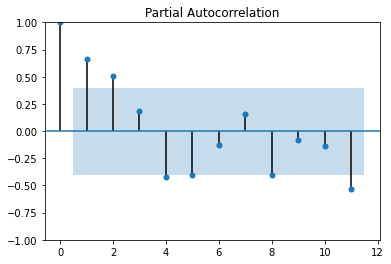

In [40]:
from statsmodels.graphics.tsaplots import plot_pacf

plot = plot_pacf(np.asarray(volumen), lags=11)

En base a la información provista por los correlogramas vemos que la serie no es estacionaria.

Podemos avanzar con este mismo análisis a través de la prueba de la raíz unitaria.

De acuerdo con el test de Dickey Fuller:

Hipótesis nula: H0 :δ = 0 (existe una raíz unitaria, la serie de tiempo es no estacionaria).

Hipótesis alternativa: H1:δ < 0 (la serie de tiempo es estacionaria)

In [36]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
adfuller(volumen,regression='c')[1]

0.4164746081165164

Dado que el p-valor = 0,41 no podemos rechazar la hipótesis nula y por lo tanto, vemos que esta serie es no estacionaria.

Probamos diferenciar la serie para volverla estacionaria.

In [ ]:
volumen_1 = volumen.diff()

Graficamos la serie

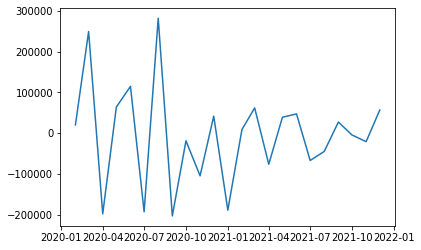

In [ ]:
plt.plot(volumen_1)

Realizamos nuevamente el test de raíz unitaria para poder estudiar si la transformación en la serie logró tornarla estacionaria.

In [37]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
adfuller(volumen_1[1:],regression='c')[1]

0.00331950191179618

Dado que p-valor < 0,05 podemos rechazar la hipótesis nula y afirmar que la serie de volumen en primeras diferencias es estacionaria.

## **Construcción del modelo**
 

Teniendo en cuenta que desestacionalimamos la serie ahora podremos continuar con la aplicación del método Box-Jenkings para aproximarnos al mejor modelo.

Esto implica la iteración sobre alternativas que minimicen los criterios de información, en este caso tomaremos el criterio de Akaike (AIC).

Haremos una serie de alternativas para luego dar paso a la función AutoArima que realiza este proceso.

#### AR(1)

Calcularemos un modelo autorregresivo de orden 1 con la integrada de primer orden.

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

res_AR_1 = ARIMA(volumen, order=(1,1,0)).fit()


In [ ]:
res_AR_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             OFS_Volume   No. Observations:                   24
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -299.287
Date:                Sun, 04 Dec 2022   AIC                            602.574
Time:                        22:00:27   BIC                            604.845
Sample:                    01-01-2020   HQIC                           603.145
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4215      0.132     -3.197      0.001      -0.680      -0.163
sigma2      1.069e+10   2.13e-13   5.03e+22      0.000    1.07e+10    1.07e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 2.03
Prob(Q):                              0.62   Prob(JB):                         0.36
Heteroskedasticity (H):               0.08   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
print(res_AR_1.params)

ar.L1    -4.215363e-01
sigma2    1.068800e+10
dtype: float64


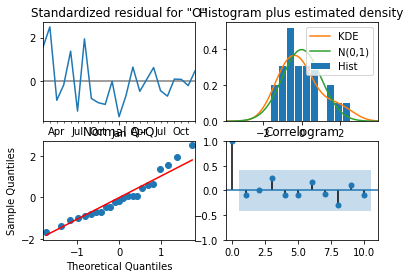

In [32]:
plot = res_AR_1.plot_diagnostics()

#### ARIMA (1,1,1)

In [ ]:
res_ARMA_1 = ARIMA(volumen, order=(1,1,1)).fit()

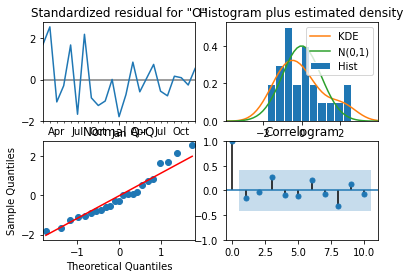

In [35]:
plot = res_ARMA_1.plot_diagnostics()

In [ ]:
res_ARMA_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             OFS_Volume   No. Observations:                   24
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -299.724
Date:                Sun, 04 Dec 2022   AIC                            605.448
Time:                        22:00:32   BIC                            608.855
Sample:                    01-01-2020   HQIC                           606.305
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5449      0.179     -3.038      0.002      -0.896      -0.193
ma.L1          0.1617      0.209      0.775      0.438      -0.247       0.571
sigma2      8.484e+09   1.44e-11   5.88e+20      0.000    8.48e+09    8.48e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.44   Prob(JB):                         0.44
Heteroskedasticity (H):               0.09   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.33e+36. Standard errors may be unstable.
"""

#### MA(1)

Modelo de Media Movil de grado 1 con una integrada.

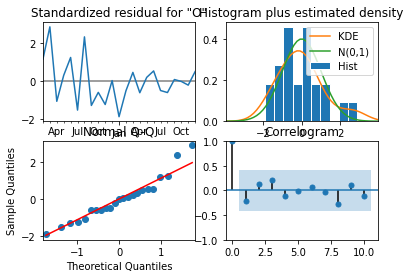

In [34]:
res_MA_1 = ARIMA(volumen, order=(0,1,1)).fit()
plot = res_MA_1.plot_diagnostics()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


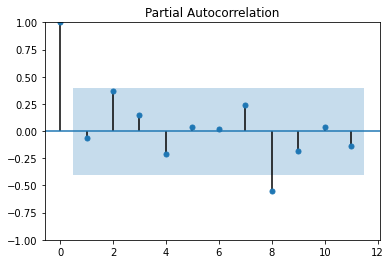

In [33]:
plot = plot_pacf(np.asarray(res_MA_1.resid), lags=11)

In [ ]:
res_MA_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             OFS_Volume   No. Observations:                   24
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -300.609
Date:                Sun, 04 Dec 2022   AIC                            605.219
Time:                        22:00:34   BIC                            607.489
Sample:                    01-01-2020   HQIC                           605.790
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3185      0.118     -2.708      0.007      -0.549      -0.088
sigma2      9.911e+09   2.15e-12    4.6e+21      0.000    9.91e+09    9.91e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.27   Jarque-Bera (JB):                 2.37
Prob(Q):                              0.26   Prob(JB):                         0.31
Heteroskedasticity (H):               0.06   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.88e+37. Standard errors may be unstable.
"""

#**Modelo Auto-ARIMA** 
Auto-ARIMA busca identificar los mejores hyperparámetros para un modelo ARIMA, decidiéndose por un único modelo ARIMA ajustado. https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

In [ ]:
model = auto_arima(volumen, start_p=0, start_q=0, trace=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=608.520, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=604.748, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=611.824, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=606.571, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=612.104, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=609.310, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=602.574, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=606.646, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=605.448, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=605.219, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.371 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -299.287
Date:                Sun, 04 Dec 2022   AIC                            602.574
Time:                        22:00:44   BIC                            604.845
Sample:                    01-01-2020   HQIC                           603.145
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4215      0.132     -3.197      0.001      -0.680      -0.163
sigma2      1.069e+10   2.13e-13   5.03e+22      0.000    1.07e+10    1.07e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 2.03
Prob(Q):                              0.62   Prob(JB):                         0.36
Heteroskedasticity (H):               0.08   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

De acuerdo a lo observado, el modelo que minimiza el crieterio de información de Akaike es un modelo Arima (1,1,0).

#**Predicción ARIMA (1,1,0)**

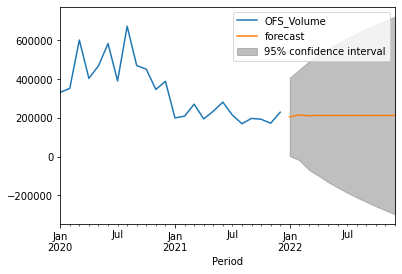

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

res = ARIMA(volumen, order=(1,1,0)).fit()


fig, ax = plt.subplots()
ax = volumen.plot(ax=ax)
plot_predict(res, start='2022-01-01', end='2022-12-01', ax=ax)
plt.show()

# TP Final: Series de tiempo - Modelo ARIMA - Parte 3
EEA - 2C 2022

**Alumnos**: 

Exequiel Di Marzo Broggio

Mauricio Acatto

# Descompocisión

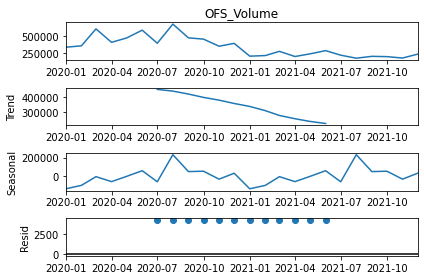

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(volumen,model='additive')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

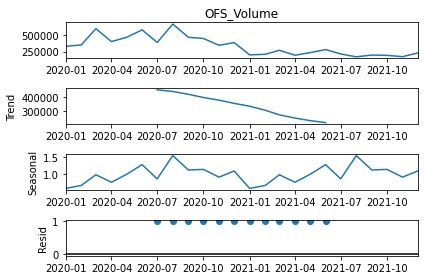

In [ ]:

decompose_result_mult = seasonal_decompose(volumen,model='multiplicable')

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [ ]:
#@title Prueba Auto-ARIMA + estacionalidad
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA


model = auto_arima(volumen, start_p=0, start_q=0, m = 12, seasonal = True, information_criterion ='aicc',  trace=True)
model.summary()

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AICC=614.495, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AICC=609.091, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AICC=608.209, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AICC=615.875, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AICC=606.753, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AICC=611.591, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AICC=611.592, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AICC=605.948, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AICC=608.234, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AICC=611.434, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AICC=614.209, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AICC=611.415, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AICC=613.024, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AICC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -299.287
Date:                Sun, 04 Dec 2022   AIC                            602.574
Time:                        22:00:48   BIC                            604.845
Sample:                    01-01-2020   HQIC                           603.145
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4215      0.132     -3.197      0.001      -0.680      -0.163
sigma2      1.069e+10   2.13e-13   5.03e+22      0.000    1.07e+10    1.07e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 2.03
Prob(Q):                              0.62   Prob(JB):                         0.36
Heteroskedasticity (H):               0.08   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

# Métricas


**AIC - Criterio de información de Akaike**

 Recompensa la bondad de ajuste y también incluye una penalidad, que es una función creciente del número de parámetros del modelo. 
 
 En éste caso para ARIMA y AIC corregido (muestras pequeñas):

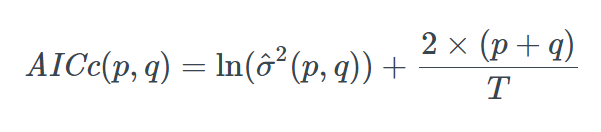

Donde:
* T es el número de valores no faltantes en la serie de tiempo.
* p es el orden del modelo componente AR.
* q es el orden del modelo componente MA.
* σ^ es la desviación estándar de los resíduos.

(fuente: https://support.numxl.com/hc/es/articles/214409946-ARMA-AIC-Criterio-de-informaci%C3%B3n-de-Akaike-AIC-de-un-modelo-ARMA)

**BIC - Criterio de información Bayesiano**

Tanto el BIC y AIC resuelven este problema mediante la introducción de un término de penalización para el número de parámetros en el modelo, el término de penalización es mayor en el BIC que en el AIC.

 En éste caso para ARIMA:

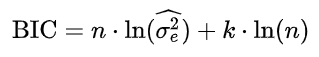

Donde:
* k es el número de parámetros
* n es el número de datos
* image.png es la varianza del error.

A diferencia de AIC, la medida de la complejidad incorpora tanto k como ln(n). Por lo tanto, los efectos de aumentar la complejidad es mas grande. Es decir, BIC penaliza más la complejidad que AIC, busca el modelo más abstracto.

Por su parte AIC dará con un modelo más complejo que hace predicciones con mayor detalle dentro de nuestros propios datos.